In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import time

In [34]:
#Read Data from soruces

# Read the sensor feature file (590 columns, no header)
df_features = pd.read_csv("C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom.data",
                          delim_whitespace=True,  # or sep=' '
                          header=None)

# Read the labels file (two columns: label and timestamp)
df_labels = pd.read_csv("C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom_labels.data",
                        delim_whitespace=True,
                        header=None)

# df_features.head()
# df_labels.head()

C:\Users\Prajakta B\AppData\Local\Temp\ipykernel_34828\885378504.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_features = pd.read_csv("C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom.data",
C:\Users\Prajakta B\AppData\Local\Temp\ipykernel_34828\885378504.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_labels = pd.read_csv("C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom_labels.data",


In [35]:
#Combining data and creating proper structure of table


# Loading dataset 
try:
    secom_data = pd.read_csv('C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom.data', delim_whitespace=True, header=None)
    labels = pd.read_csv('C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom_labels.data', delim_whitespace=True, header=None)
except FileNotFoundError as e:
    print(f"Error: {e}. Please verify file paths and names.")
    exit()
    
# Rename columns like feature_1,2.. target_1,2..
num_sensors = secom_data.shape[1]  # Number of sensor columns
new_columns = [f'feature_{i+1}' for i in range(num_sensors)] 
secom_data.columns = new_columns

labels.columns = ["is_faulty", "date_time"]

df = pd.concat([
          secom_data, labels
], axis=1)

C:\Users\Prajakta B\AppData\Local\Temp\ipykernel_34828\4161458270.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  secom_data = pd.read_csv('C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom.data', delim_whitespace=True, header=None)
C:\Users\Prajakta B\AppData\Local\Temp\ipykernel_34828\4161458270.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv('C:/Users/Prajakta B/Desktop/SECOM_DATA/secom/secom_labels.data', delim_whitespace=True, header=None)


In [36]:
# Test & train dataset split with stratified sampling
from sklearn.model_selection import train_test_split

feature_colms = [col for col in df.columns if col not in ['is_faulty']]
# Features: all columns starting with 'feature_'
X = df[feature_colms]

# Target: 'is_faulty'
y = df['is_faulty']

# Show frequency distribution before sampling
print("Frequency distribution BEFORE sampling:")
print(y.value_counts(normalize=True).rename('proportion').to_frame())
print(y.value_counts().rename('count').to_frame())
print('-' * 40)

# Stratified train-test split (67% train, 33% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,        # 20% test, 80% train
    random_state=42,       # seed value
    stratify=y             # Stratified split based on is_faulty
)


# Show frequency distribution in train set
print("Frequency distribution in TRAIN set:")
print(y_train.value_counts(normalize=True).rename('proportion').to_frame())
print(y_train.value_counts().rename('count').to_frame())
print('-' * 40)

# Show frequency distribution in test set
print("Frequency distribution in TEST set:")
print(y_test.value_counts(normalize=True).rename('proportion').to_frame())
print(y_test.value_counts().rename('count').to_frame())
print('-' * 40)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df_clean = pd.concat([X_train, y_train], axis=1)
# Display datasets
# train_df
# test_df 
# train_df_clean

Frequency distribution BEFORE sampling:
           proportion
is_faulty            
-1           0.933631
 1           0.066369
           count
is_faulty       
-1          1463
 1           104
----------------------------------------
Frequency distribution in TRAIN set:
           proportion
is_faulty            
-1           0.933759
 1           0.066241
           count
is_faulty       
-1          1170
 1            83
----------------------------------------
Frequency distribution in TEST set:
           proportion
is_faulty            
-1           0.933121
 1           0.066879
           count
is_faulty       
-1           293
 1            21
----------------------------------------


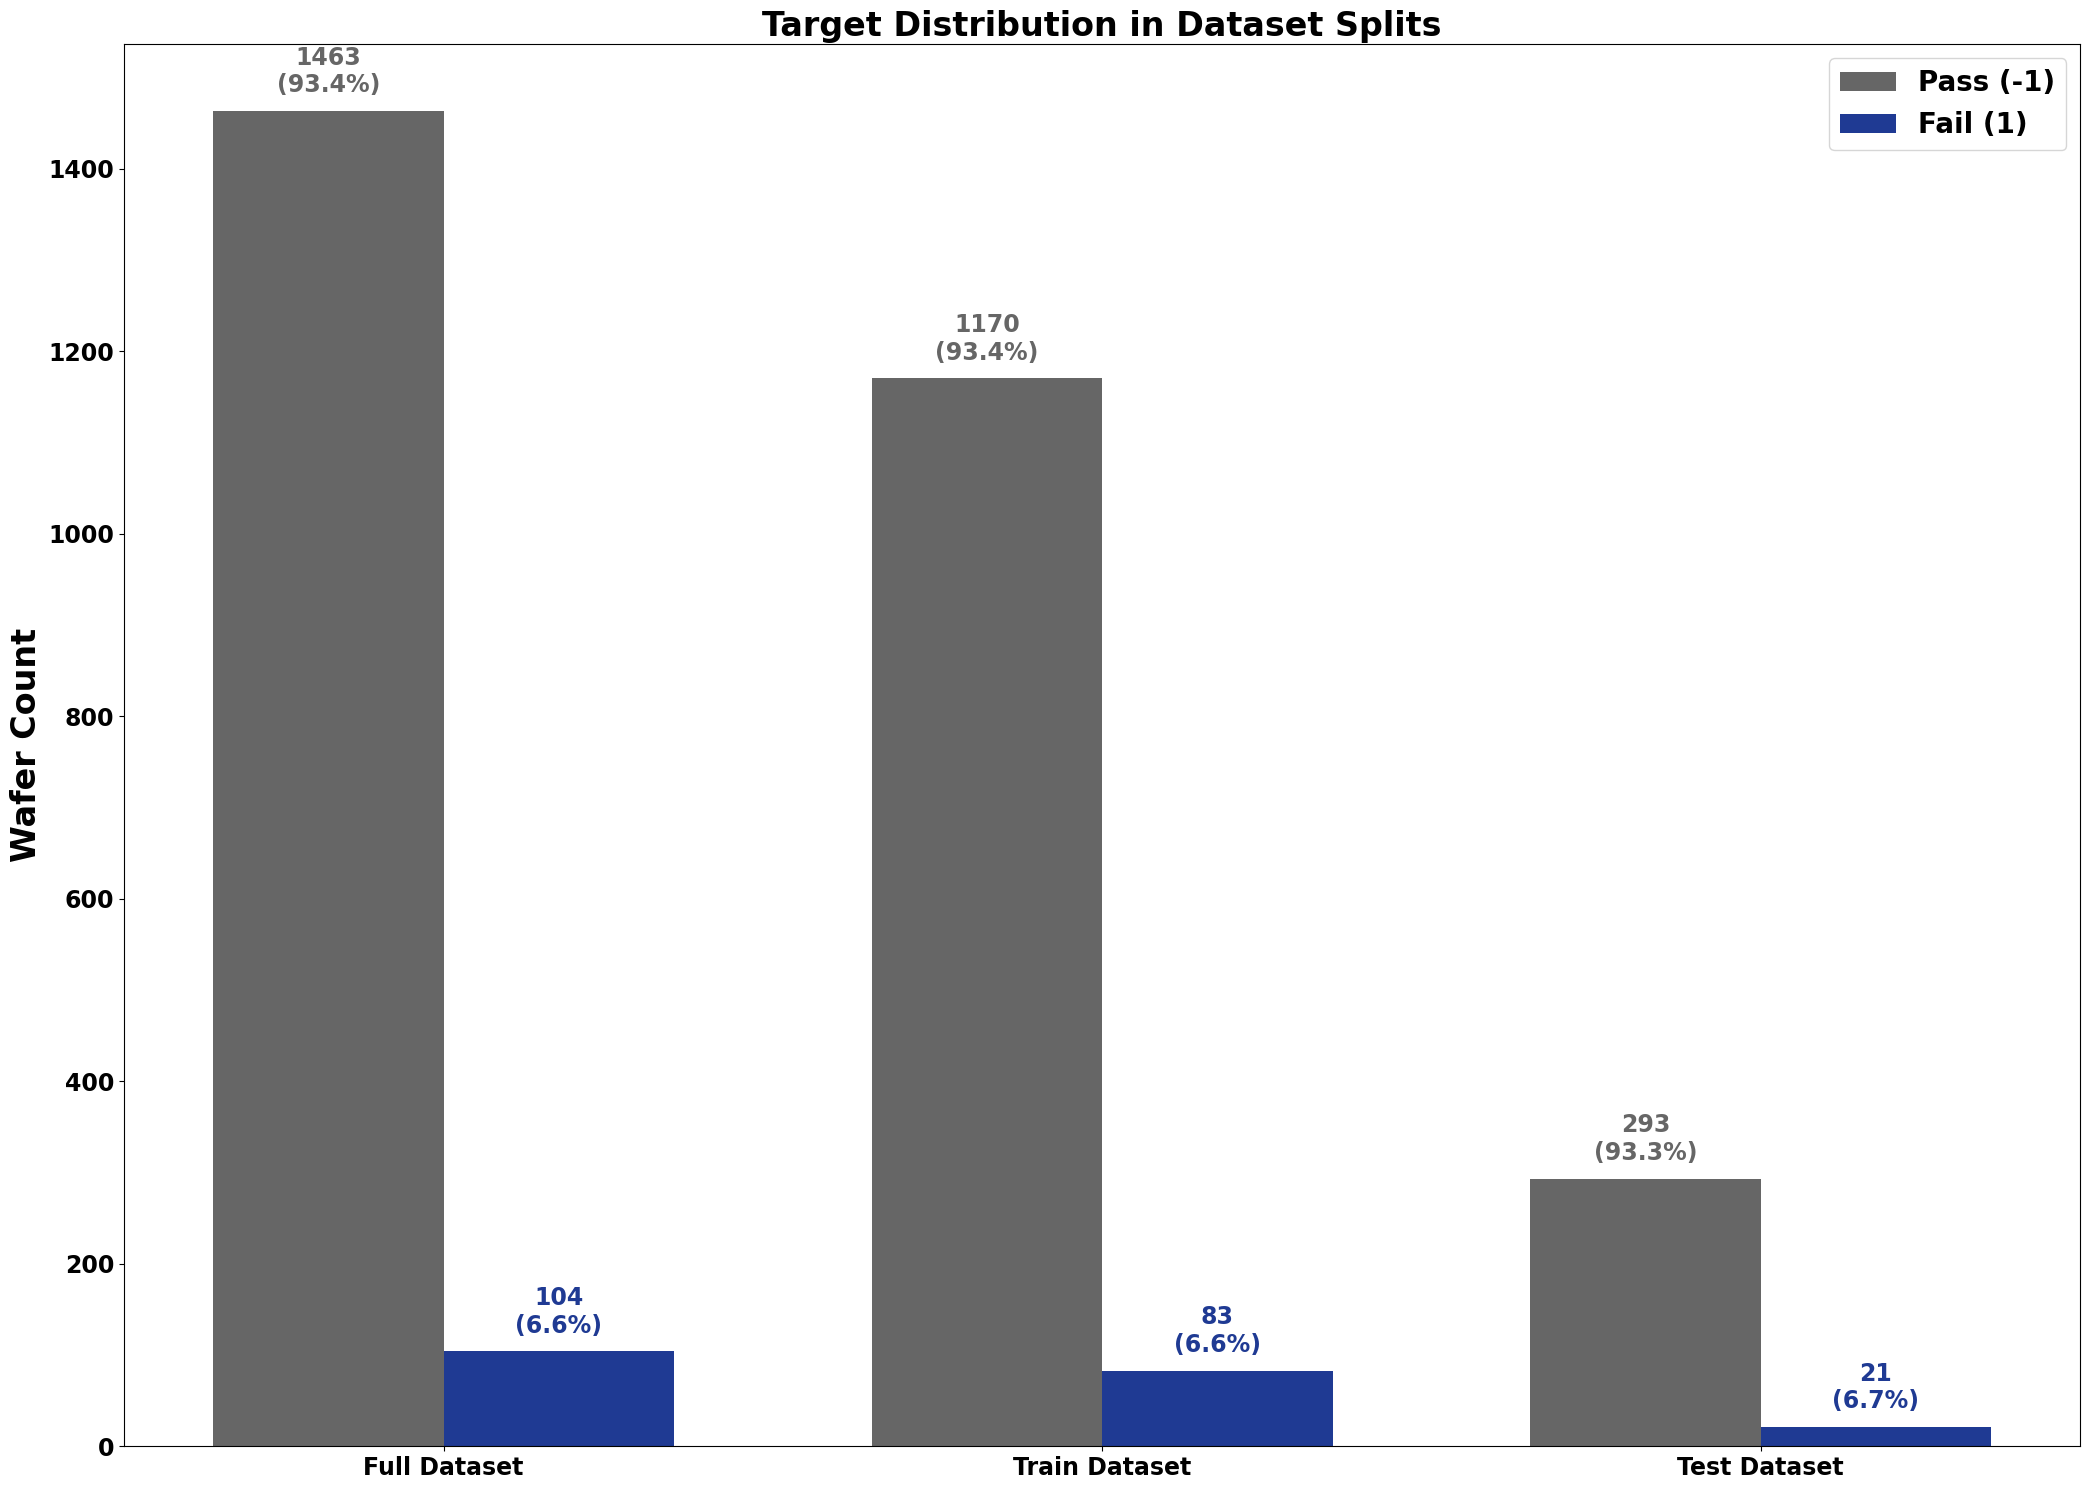

In [37]:
#Test split distribution visualisation for PPT

# Data
labels = ['Full Dataset', 'Train Dataset', 'Test Dataset']
non_faulty = [1463, 1170, 293]  # Pass
faulty = [104, 83, 21]          # Fail
totals = [n + f for n, f in zip(non_faulty, faulty)]
non_faulty_pct = [n / t * 100 for n, t in zip(non_faulty, totals)]
faulty_pct = [f / t * 100 for f, t in zip(faulty, totals)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(21, 15))

rects1 = ax.bar(x - width/2, non_faulty, width, label='Pass (-1)', color='#666666')
rects2 = ax.bar(x + width/2, faulty, width, label='Fail (1)', color='#1F3A93')

# Set bold font properties
bold_font = {'fontsize': 24, 'fontweight': 'bold'}

ax.set_ylabel('Wafer Count', **bold_font)
ax.set_title('Target Distribution in Dataset Splits', **bold_font)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=17, fontweight='bold')

# Set bold font for y-tick labels
ax.tick_params(axis='y', labelsize=17)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Set bold font for legend
legend = ax.legend(fontsize=20)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Annotate bars with counts and percentages in bold
for i in range(len(labels)):
    ax.text(
        x[i] - width/2, non_faulty[i] + 15,
        f'{non_faulty[i]}\n({non_faulty_pct[i]:.1f}%)',
        ha='center', va='bottom', fontsize=17, color='#666666', fontweight='bold'
    )
    ax.text(
        x[i] + width/2, faulty[i] + 15,
        f'{faulty[i]}\n({faulty_pct[i]:.1f}%)',
        ha='center', va='bottom', fontsize=17, color='#1F3A93', fontweight='bold'
    )

plt.tight_layout()
plt.show()



In [38]:
# Data cleaning in train dataset train_df_clean
# zero volatality columns (0 variance)

# Count initial columns (including target)
initial_col_count = train_df_clean.shape[1]
print(f"\nInitial number of columns: {initial_col_count}")

# Identify feature columns (exclude target)
feature_cols = [col for col in df.columns if col not in ['is_faulty', 'date_time']]

# Find zero-volatility columns (std = 0)
stds = train_df_clean[feature_cols].std()
zero_vol_cols = stds[stds == 0].index.tolist()

# Remove zero-volatility columns
train_df_clean = train_df_clean.drop(columns=zero_vol_cols)

# Count final columns (including target)
final_col_count = train_df_clean.shape[1]
print(f"Number of zero-volatility columns removed: {len(zero_vol_cols)}")
print(f"Final number of columns: {final_col_count}")
# print(train_df_clean)



Initial number of columns: 592
Number of zero-volatility columns removed: 116
Final number of columns: 476


In [39]:
# missing values column dropping
# Count columns before removal
before_cols = train_df_clean.shape[1]
print(f"Number of columns before removal: {before_cols}")

# Calculate the percentage of missing values in each column
missing_percent = train_df_clean.isnull().mean()


# Identify columns with more than 44% missing values (44% because there is suddent drop in missing value percentage like 18%)
cols_to_drop = missing_percent[missing_percent > 0.44].index.tolist()

print(f"Number of columns with >50% missing values: {len(cols_to_drop)}")
print("Columns to drop due to missing values >50%:")
print(cols_to_drop)

# Drop these columns
train_df_clean = train_df_clean.drop(columns=cols_to_drop)

# Count columns after removal
after_cols = train_df_clean.shape[1]
print(f"Number of columns after removal: {after_cols}")
print(f"Number of columns removed: {before_cols - after_cols}")


Number of columns before removal: 476
Number of columns with >50% missing values: 32
Columns to drop due to missing values >50%:
['feature_73', 'feature_74', 'feature_86', 'feature_110', 'feature_111', 'feature_112', 'feature_113', 'feature_158', 'feature_159', 'feature_221', 'feature_245', 'feature_246', 'feature_247', 'feature_248', 'feature_293', 'feature_294', 'feature_346', 'feature_347', 'feature_359', 'feature_383', 'feature_384', 'feature_385', 'feature_386', 'feature_493', 'feature_517', 'feature_518', 'feature_519', 'feature_520', 'feature_579', 'feature_580', 'feature_581', 'feature_582']
Number of columns after removal: 444
Number of columns removed: 32


In [40]:
# High Correlation columns

from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd

# Initial column count
initial_cols = train_df_clean.shape[1]

# Identify feature columns (exclude target and date)
feature_cols = [col for col in train_df_clean.columns if col not in ['is_faulty', 'date_time']]

# Ensure all features are numeric 
X = train_df_clean[feature_cols]
if X.select_dtypes(include=['object', 'category']).shape[1] > 0:
    X = pd.get_dummies(X)
X = X.fillna(0)

# Compute MI scores
y = train_df_clean['is_faulty'].values
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)

# Compute correlation matrix and its upper triangle
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.8
to_drop = set()

# For each pair of highly correlated columns, drop the one with lower MI
for col in upper.columns:
    for row in upper.index:
        if pd.notnull(upper.loc[row, col]) and upper.loc[row, col] > threshold:
            if mi_series[col] < mi_series[row]:
                to_drop.add(col)
            else:
                to_drop.add(row)

# Drop the selected columns
train_df_clean = train_df_clean.drop(columns=list(to_drop))

# Print results
print(f"Columns dropped due to high correlation: {len(to_drop)}")
print("\nList of dropped columns:")
print(list(to_drop))

# Final count
final_cols = train_df_clean.shape[1]
print(f"\nInitial columns: {initial_cols}")
print(f"Final columns: {final_cols}")






Columns dropped due to high correlation: 237

List of dropped columns:
['feature_338', 'feature_301', 'feature_99', 'feature_390', 'feature_340', 'feature_527', 'feature_280', 'feature_284', 'feature_220', 'feature_422', 'feature_445', 'feature_357', 'feature_431', 'feature_19', 'feature_358', 'feature_97', 'feature_283', 'feature_410', 'feature_322', 'feature_334', 'feature_185', 'feature_186', 'feature_279', 'feature_252', 'feature_561', 'feature_575', 'feature_199', 'feature_389', 'feature_480', 'feature_556', 'feature_141', 'feature_456', 'feature_226', 'feature_125', 'feature_67', 'feature_288', 'feature_364', 'feature_94', 'feature_555', 'feature_134', 'feature_210', 'feature_291', 'feature_474', 'feature_574', 'feature_178', 'feature_68', 'feature_312', 'feature_304', 'feature_197', 'feature_528', 'feature_224', 'feature_586', 'feature_139', 'feature_51', 'feature_566', 'feature_200', 'feature_217', 'feature_13', 'feature_47', 'feature_344', 'feature_171', 'feature_421', 'featur

In [41]:
# 3 sigma outlier detection
import numpy as np
import pandas as pd
from scipy.stats import zscore

#  Identify feature columns (exclude target and date)
feature_cols = [col for col in train_df_clean.columns if col not in ['is_faulty', 'date_time']]

# Prepare list to collect results
results = []

for col in feature_cols:
    if col in train_df_clean.columns:
        z_scores = zscore(train_df_clean[col])
        outliers = np.abs(z_scores) > 3
        percent_outliers = 100 * np.sum(outliers) / len(train_df_clean[col])
        results.append({'Feature': col, 'Outlier_Percentage': percent_outliers})

# Create a DataFrame from the results
outlier_df = pd.DataFrame(results)

# Sort by Outlier_Percentage in descending order
outlier_df = outlier_df.sort_values(by='Outlier_Percentage', ascending=False).reset_index(drop=True)

# Display the table
print(outlier_df)

# Impute missing values before capping outliers.
# This ensures your outlier detection and capping are based on accurate, complete feature statistics and aligns with published research and industry practice for this datase
# https://pmc.ncbi.nlm.nih.gov/articles/PMC11398254/
# https://github.com/Eason0227/Semiconductor-Manufacturing-Procees-Prediction

#Capping
# for col in feature_cols:
#     if col in train_df_clean.columns:
#         mean = train_df_clean[col].mean()
#         std = train_df_clean[col].std()
#         upper_limit = mean + 3 * std
#         lower_limit = mean - 3 * std
#         train_df_clean[col] = np.where(train_df_clean[col] > upper_limit, upper_limit, train_df_clean[col])
#         train_df_clean[col] = np.where(train_df_clean[col] < lower_limit, lower_limit, train_df_clean[col])



         Feature  Outlier_Percentage
0     feature_39            4.868316
1    feature_578            3.671189
2     feature_36            2.474062
3    feature_572            2.314445
4     feature_37            2.075020
..           ...                 ...
200  feature_583            0.000000
201  feature_584            0.000000
202  feature_587            0.000000
203  feature_589            0.000000
204  feature_590            0.000000

[205 rows x 2 columns]


In [ ]:
# Imputation pipeline -Scaling ==> imputatio KNN and MICE ==> capping
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Identify feature columns (exclude target and date)
feature_cols = [col for col in train_df_clean.columns if col not in ['is_faulty', 'date_time']]

# Scale the feature columns
scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(train_df_clean[feature_cols]),
    columns=feature_cols,
    index=train_df_clean.index
)

# --- MICE Imputation ---
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
features_imputed_mice = pd.DataFrame(
    mice_imputer.fit_transform(features_scaled),
    columns=feature_cols,
    index=features_scaled.index
)

# --- KNN Imputation ---
knn_imputer = KNNImputer(n_neighbors=5)
features_imputed_knn = pd.DataFrame(
    knn_imputer.fit_transform(features_scaled),
    columns=feature_cols,
    index=features_scaled.index
)

# --- 3-sigma capping using zscore ---
def cap_outliers_3sigma_zscore(df, feature_cols):
    capped = df.copy()
    zscores = zscore(capped[feature_cols], nan_policy='omit')
    # Cap values at -3 and +3 in z-score space
    capped[feature_cols] = np.clip(zscores, -3, 3)
    return capped

# Apply capping to imputed features
features_imputed_mice_capped = cap_outliers_3sigma_zscore(features_imputed_mice, feature_cols)
features_imputed_knn_capped = cap_outliers_3sigma_zscore(features_imputed_knn, feature_cols)

# Combine imputed and capped features with non-feature columns
non_feature_cols = [col for col in train_df_clean.columns if col not in feature_cols]

train_df_imputed_mice = pd.concat(
    [train_df_clean[non_feature_cols], features_imputed_mice_capped],
    axis=1
)[train_df_clean.columns]

train_df_imputed_knn = pd.concat(
    [train_df_clean[non_feature_cols], features_imputed_knn_capped],
    axis=1
)[train_df_clean.columns]

# Preview the results
print("MICE-imputed and capped DataFrame:")
print(train_df_imputed_mice.head())
print("\nKNN-imputed and capped DataFrame:")
print(train_df_imputed_knn.head())



C:\Users\Prajakta B\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


MICE-imputed and capped DataFrame:
      feature_1  feature_2  feature_3  feature_4  feature_9  feature_10  \
1198   0.839550  -0.069444  -0.514973  -0.437606  -0.870411   -0.925579   
436    0.788228  -0.089466   0.585376   0.084628   0.851037    0.508997   
635    0.046522   0.343761   0.029333  -1.185377  -1.253257    0.039619   
996   -1.544062   0.911387   0.807722   0.831119   1.774211   -1.004911   
782   -0.432945  -0.372403  -2.816432  -1.153054  -0.305646   -0.561977   

      feature_11  feature_12  feature_15  feature_16  ...  feature_571  \
1198   -0.078933    0.730433   -2.100351   -0.946795  ...    -0.025558   
436    -1.348640   -0.335044    0.451495   -0.523677  ...     0.024118   
635     0.545161    0.250968    0.448586    0.170905  ...     0.210417   
996     0.642003    1.468656   -0.155941   -0.921816  ...     0.088676   
782     0.050190    0.989191    1.228926    1.366290  ...     0.278087   

      feature_572  feature_578  feature_583  feature_584  feature_587

In [50]:
#Feature selection with Boruta, RFE and LASSO

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler

# Assign imputed DataFrame to train_df_FS for feature selection
train_df_FS = train_df_imputed_mice.copy()

# Prepare data
X = train_df_FS[feature_cols].values
y = train_df_FS['is_faulty'].values

# Standardize features for LASSO and RFE (important for regularization methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Boruta Feature Selection
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta_selector.fit(X, y)
boruta_support = boruta_selector.support_
boruta_selected_features = [feature for feature, support in zip(feature_cols, boruta_support) if support]
print(f"Boruta selected {len(boruta_selected_features)} features")

# 2. Recursive Feature Elimination (RFE) with Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
rfe_selector = RFE(logreg, n_features_to_select=20)  # Choose top 20 or any number you prefer
rfe_selector.fit(X_scaled, y)
rfe_support = rfe_selector.support_
rfe_selected_features = [feature for feature, support in zip(feature_cols, rfe_support) if support]
print(f"RFE selected {len(rfe_selected_features)} features")

# 3. LASSO (L1) Feature Selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
lasso.fit(X_scaled, y)
lasso_support = lasso.coef_[0] != 0
lasso_selected_features = [feature for feature, support in zip(feature_cols, lasso_support) if support]
print(f"LASSO selected {len(lasso_selected_features)} features")

# Intersection (features selected by all three methods)
intersection_features = list(set(boruta_selected_features) & set(rfe_selected_features) & set(lasso_selected_features))
print(f"Features selected by all three methods (intersection): {len(intersection_features)}")

# --- Create DataFrames for modeling ---

# Boruta-selected features + target
df_boruta = train_df_FS[boruta_selected_features + ['is_faulty']].copy()

# RFE-selected features + target
df_rfe = train_df_FS[rfe_selected_features + ['is_faulty']].copy()

# LASSO-selected features + target
df_lasso = train_df_FS[lasso_selected_features + ['is_faulty']].copy()

# Intersection-selected features + target
df_intersection = train_df_FS[intersection_features + ['is_faulty']].copy()

# Example: print shapes
print("Boruta DataFrame shape:", df_boruta.shape)
print("RFE DataFrame shape:", df_rfe.shape)
print("LASSO DataFrame shape:", df_lasso.shape)
print("Intersection DataFrame shape:", df_intersection.shape)



Boruta selected 14 features
RFE selected 20 features
LASSO selected 172 features
Features selected by all three methods (intersection): 5
Boruta DataFrame shape: (1253, 15)
RFE DataFrame shape: (1253, 21)
LASSO DataFrame shape: (1253, 173)
Intersection DataFrame shape: (1253, 6)


In [51]:
#Balancing with SMOTE
from imblearn.over_sampling import SMOTE

def apply_smote(df, target_col='is_faulty'):
    features = [col for col in df.columns if col != target_col]
    X = df[features]
    y = df[target_col]
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    # Recombine into DataFrame
    df_balanced = pd.concat([pd.DataFrame(X_res, columns=features), 
                             pd.Series(y_res, name=target_col)], axis=1)
    return df_balanced

# Apply SMOTE to each feature-selected DataFrame
df_boruta_balanced = apply_smote(df_boruta)
df_rfe_balanced = apply_smote(df_rfe)
df_lasso_balanced = apply_smote(df_lasso)
df_intersection_balanced = apply_smote(df_intersection)

# Optional: Check class balance
print("Boruta:", df_boruta_balanced['is_faulty'].value_counts())
print("RFE:", df_rfe_balanced['is_faulty'].value_counts())
print("LASSO:", df_lasso_balanced['is_faulty'].value_counts())
print("Intersection:", df_intersection_balanced['is_faulty'].value_counts())

Boruta: is_faulty
-1    1170
 1    1170
Name: count, dtype: int64
RFE: is_faulty
-1    1170
 1    1170
Name: count, dtype: int64
LASSO: is_faulty
-1    1170
 1    1170
Name: count, dtype: int64
Intersection: is_faulty
-1    1170
 1    1170
Name: count, dtype: int64


In [52]:
# # Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Example: use Boruta-selected balanced data
df = df_boruta_balanced  # or df_rfe_balanced, df_lasso_balanced, df_intersection_balanced

# Separate features and target
X = df.drop(columns=['is_faulty'])
y = df['is_faulty']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# 3. SVM (with probability estimates enabled)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSVM Results:")
print(classification_report(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1]))


Logistic Regression Results:
              precision    recall  f1-score   support

          -1       0.69      0.67      0.68       234
           1       0.68      0.70      0.69       234

    accuracy                           0.68       468
   macro avg       0.68      0.68      0.68       468
weighted avg       0.68      0.68      0.68       468

ROC AUC: 0.7662174008327853

Random Forest Results:
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       234
           1       0.95      0.95      0.95       234

    accuracy                           0.95       468
   macro avg       0.95      0.95      0.95       468
weighted avg       0.95      0.95      0.95       468

ROC AUC: 0.9912247059682957

SVM Results:
              precision    recall  f1-score   support

          -1       0.94      0.80      0.87       234
           1       0.83      0.95      0.88       234

    accuracy                           0.88       468
   ma

In [46]:
# y_train_final = train_df_clean["is_faulty"]
# X_train_final = train_df_clean.drop(columns=["is_faulty","date_time"])
# # X_test_final = X_test_imputed.drop(columns=high_corr_to_drop)

# # y_train_arr = y_train.drop(columns='date_time')
# y_train_final = y_train_final.to_numpy()

# # Numerical Columns
# numerical_columns = X_train_final.columns.to_list()

# # Numerical Preprocessing Pipeline: Impute missing values with median and scale
# numerical_pipeline = Pipeline(
#     steps=[
#         #('imputer', SimpleImputer(strategy='median')),
#         ('scaler', MinMaxScaler())
#     ]
# )

# # Combine into a Column Transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num_pipeline', numerical_pipeline, numerical_columns)
#     ]
# )

# # %%
# # Define Models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1),
#     'Random Forest': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
#     'SVM': SVC(class_weight='balanced')
# }

# # Define scoring metrics for imbalanced data (focus on class 1 = failure)
# scoring = {
#     'precision': make_scorer(precision_score, average='binary', pos_label=1),
#     'recall': make_scorer(recall_score, average='binary', pos_label=1),
#     'f1': make_scorer(f1_score, average='binary', pos_label=1)
# }

# # Stratified cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Run CV for each model
# results = []

# for model_name, model in models.items():
#     pipeline = Pipeline(steps=[
#         ('preprocessing', preprocessor),
#         ('classifier', model)
#     ])

#     print(f"Training {model_name}...")
#     start_time = time.time()
    
#     y_pred = cross_val_predict(pipeline, X_train_final, y_train_final, cv=cv)
#     execution_time = round(time.time() - start_time, 2)
    
#     # Compute Metrics (still targeting Fail class = 1 as positive class)
#     precision = round(precision_score(y_train_final, y_pred, pos_label=1), 4)
#     recall = round(recall_score(y_train_final, y_pred, pos_label=1), 4)
#     f1 = round(f1_score(y_train_final, y_pred, pos_label=1), 4)

#     # Standard format: [[TN, FP], [FN, TP]]
#     # Negative class: -1 (Pass), Positive class: 1 (Fail)
#     cm_raw = confusion_matrix(y_train_final, y_pred, labels=[-1, 1])
#     tn, fp = cm_raw[0]
#     fn, tp = cm_raw[1]
#     cm = np.array([[tn, fp],
#                    [fn, tp]])


#     results.append({
#         'Model': model_name,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Confusion Matrix': cm,
#         'Execution Time (s)': execution_time
#     })

# results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
# print("\n📈 Model Comparison:\n")
# print(results_df)
 